# Geo Alpha Algotrader Challenge

### 0) Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

Assumptions/Idealizations:

1. Open-close difference is the closing price minus opening price of a each day.
2. Open price is equal to previous days close price. (Sometimes there are out of hours trading which is unavailable)
3. There exists a daily inverse AAPL fund which allows us to short AAPL on a daily basis when we think the stock will go down.
4. If required we can buy/sell APPL or 'inverse AAPL' exactly at the beginning or end of the day.

### 1) Preprocess Data

In [2]:
raw_DF = pd.read_csv("../data/AAPL_OC_return.csv")
DF = raw_DF["AAPL"] # Ignore any signal in date field for now.

##### Histogram to 'eye-ball' confirm open-close differences correspond to AAPL stock going up more often than down.

<AxesSubplot:ylabel='Frequency'>

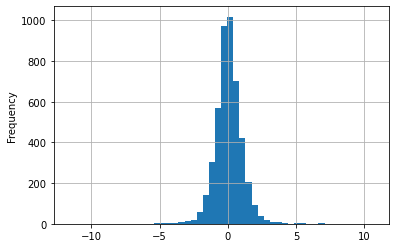

In [3]:
DF.plot.hist(grid=True, bins=50)

First 3000 days will be used for training, the remaining 1625 days will be used for testing performance.

In [4]:
maximum = DF.max()
#DF_scaled = scaler.fit_transform(DF.values.reshape(-1,1))
DF_scaled = DF/maximum # this way negative numbers stay negative and positive numbers stay positive
train_data_scaled = DF_scaled[:3000]

### 2) Helper Functions

In [5]:
def compound_returns(change_predictions):
    
    trading_total = []
    trading_daily = []
    opening_balance = 10000
    
    for actual_change, predicted_change in zip(DF[3000:], change_predictions):
        
        # correctly predict rise, add positive actual_change to balance
        if actual_change >= 0 and predicted_change >= 0: 
            closing_balance = opening_balance*(1 + actual_change/100)
        # correctly predict drop, subtract negative actual_change to balance
        elif actual_change < 0 and predicted_change < 0:
            closing_balance = opening_balance*(1 - actual_change/100)
        # incorrectly predict drop, subtract positive actual_change to balance
        elif actual_change >= 0 and predicted_change < 0:
            closing_balance = opening_balance*(1 - actual_change/100)
        # incorrectly predict rise, add negative actual_change to balance
        elif actual_change < 0 and predicted_change >= 0:
            closing_balance = opening_balance*(1 + actual_change/100)
        else:
            raise ValueError('Percentage change issue.')
        
        trading_daily.append(closing_balance - opening_balance)
        trading_total.append(closing_balance)
        opening_balance = closing_balance
        
    return trading_daily, trading_total

In [6]:
def compound_actual_returns():
    total_returns = []
    daily_returns = []

    opening = 10000

    for percent_change in DF[3000:]:
           
        close = opening*(1 + (percent_change/100))
        daily_returns.append(close - opening)
        total_returns.append(close)
        opening = close
        
    return daily_returns, total_returns

In [7]:
def feature_target(N, time_series):
    """
    Create feature-target pairs from a time series for model training.
    The feature is a vector of N values corresponding to the consecutive sequence from i to j-1, where j-1-i=N.
    The target is a scalar corresponding to the j(th) value.
    """

    X = []
    y = []

    for j in range(N, len(time_series)):
        X.append(time_series[j-N:j, 0])
        y.append(time_series[j, 0])
    
    X = np.array(X) # can this be more compact?
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    return X, np.array(y)

In [36]:
def build_model(units, input_shape, dropout, activation):
    
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape, dropout=dropout))
    model.add(LSTM(units=units, return_sequences=True, dropout=dropout))
    #model.add(LSTM(units=units, return_sequences=True, dropout=dropout))
    model.add(LSTM(units=units, dropout=dropout))
    model.add(Dense(units = 1, activation=activation))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    return model

In [9]:
def create_matrix():
    # columns and rows could be made arguments but hardwire for now.
    columns = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "Decemeber"]
    rows = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
    
    matrix_df = pd.DataFrame(columns = columns)
    matrix_df["Year"] = rows
    matrix_df = matrix_df.set_index("Year")
    
    for col in matrix_df.columns:
        matrix_df[col].values[:] = 0
        
    return matrix_df

In [10]:
def populate_matrix(matrix_df, metric_df):
    """
    metric_df is the result of a groupby on year and month.
    """
    month_dict = dict([(i+1, month) for i, month in enumerate(matrix_df.columns)])
    for x, (year, month) in zip(metric_df, metric_df.index):
        matrix_df.at[year, month_dict[month]] = x
        
    return None

In [11]:
def populate_sharpe_matrix(annualized_sharpe_matrix_df, PnL_matrix_df, month_opens_matrix_df):
    
    dict_month = dict([(month, i+1) for i, month in enumerate(annualized_sharpe_matrix_df.columns)])
    
    month_ror_list = []
    for i, row in PnL_matrix_df.iterrows():
        for month in PnL_matrix_df.columns:
        
            # Warning: if clause hardwired.
            if (dict_month[month] > 11 or i > 2011) and (dict_month[month] < 7 and i < 2019):
          
                month_ror_list.append(row[month]/month_opens_matrix_df.loc[i, month])
        
            if len(month_ror_list) > 1:    
        
                sum_diff = 0
                for month_ror in month_ror_list:
                    sum_diff += (month_ror - 0.002)
        
                r = sum_diff/len(month_ror_list)
       
                sum_diff_sd = 0
                for month_ror in month_ror_list:
                    sum_diff_sd += math.pow((month_ror - 0.002 - r), 2)
            
                sigma_sqrd = sum_diff_sd/(len(month_ror_list) - 1)
                sigma = math.sqrt(sigma_sqrd)
            
                sharpe = r/sigma
                annualized_sharpe_matrix_df.at[i, month] = sharpe*math.sqrt(12)
            
    return None

In [12]:
def max_drawdown(total_PnL, window):
    rolling_max = total_PnL.rolling(window, min_periods=1).max()
    daily_drawdown = total_PnL/rolling_max - 1.0
    max_drawdown = daily_drawdown.rolling(window, min_periods=1).min()
    
    return max_drawdown

### 3) Model Training

#### 3.1) LSTM Neural Network Approach

In [37]:
all_predictions = []
all_actuals = []
for N in [3, 7, 15]: #, 30, 50, 100]: #, 7, 11, 17, 23, 31, 41, 47, 59, 50]:
    
    lstm_units = N
    dropout = 0.1
    activation = 'tanh'
    
    X, y = feature_target(N, train_data_scaled.values.reshape(-1,1)) #.values.reshape(-1,1)) # RED FLAG scaled deleted
    
    model = build_model(lstm_units, (X.shape[1], 1), dropout, activation)
    model.fit(X, y, epochs = 20, batch_size = 32)
    
    test_data_scaled = DF_scaled[3000-N:]
    X_test, _ = feature_target(N, test_data_scaled.values.reshape(-1,1))
    
    y_hat = model.predict(X_test)
    
    all_predictions.append(y_hat)    

Epoch 1/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 2/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 3/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 4/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 5/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 6/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 7/20
94/94 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 8/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 9/20
94/94 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 10/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 11/20
94/94 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 12/20
94/94 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 13/20
94/94 [==============================

In [14]:
y_actual = DF_scaled[3000:].values

Below I plot the LSTM model predictions agains the actual targets for windows of time, in this case, 3, 7 and 15 days. But I rescale the graphs so you will percentage changes. 

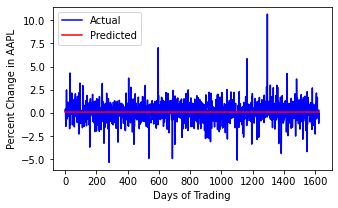

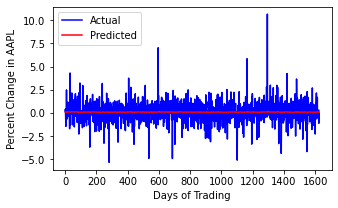

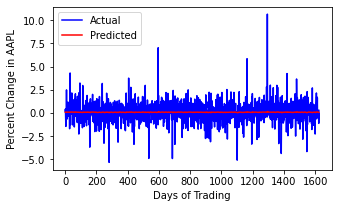

In [15]:
for j, N in [(0, 3), (1, 7), (2, 15)]:#, (3, 30), (4, 50), (5, 100)]:
    plt.figure(figsize=(5,3))
    plt.plot(y_actual*maximum, color='blue', label='Actual')
    plt.plot(all_predictions[j]*maximum, color='red', label='Predicted')
    plt.xlabel('Days of Trading')
    plt.ylabel('Percent Change in AAPL')
    plt.legend()
    plt.show()

Below I plot the predictions for N = 3, 7, 15 together. Their peaks and troughs do match those of each other and the actual targets, but their variance is much lower, and the prediction is always possible. I interpret this as the LSTM model quickly learning that Apple stocks are more likely to go up than down, which means the model has no real predictive value, since it doesn't help us short.

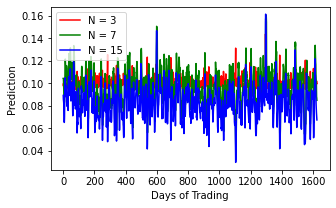

In [16]:
plt.figure(figsize=(5,3))
plt.plot(all_predictions[0]*maximum, color='red', label='N = 3')
plt.plot(all_predictions[1]*maximum, color='green', label='N = 7')
plt.plot(all_predictions[2]*maximum, color='blue', label='N = 15')
#plt.plot(all_predictions[3], color='black', label='Predicted Apple Stock Price')
#plt.plot(all_predictions[4], color='orange', label='Predicted Apple Stock Price')
#plt.plot(all_predictions[5], color='brown', label='Predicted Apple Stock Price')
plt.xlabel('Days of Trading')
plt.ylabel('Prediction')
plt.legend()
plt.show()

Below I plot the actual targets versus predictions for N = 3, 7, and 15. These plots confirm that the model has little to no predictive value. If the LSTM model had predictive power we would see points grouped along a diagonal line with positive gradient, instead the points a distributed normally around the origin. 

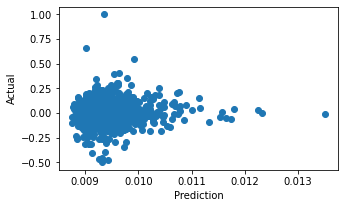

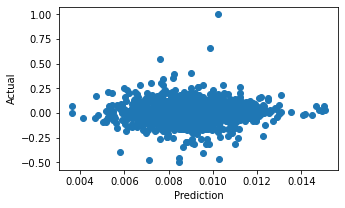

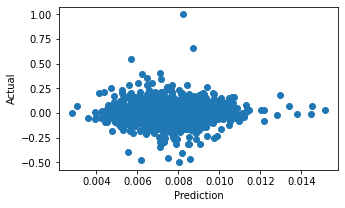

In [17]:
for j, N in [(0, 3), (1, 7), (2, 15)]:#, (3, 30), (4, 50), (5, 100)]:
    plt.figure(figsize=(5, 3))
    plt.scatter(all_predictions[j], y_actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

Since LSTM model prediction is always positive the trading balance based on its strategy will be the same as the buy and hold strategy.

#### 3.2) Crude "Momentum" Model (just to make the statistics more interesting)

To make the statistical comparison more interesting I also consider a crude momentum strategy - predict tomorrows return will be the same as today's:

In [18]:
crude_mom_prediction = DF[2999:-1].values

But from the graph below we can already see that this strategy has very little to no predictive power, we also see that the general pattern is the same as for the LSTM approach, which suggests to me that the LSTM model learned to predicted a little higher when previous days were up and a little lower when previous days were down.

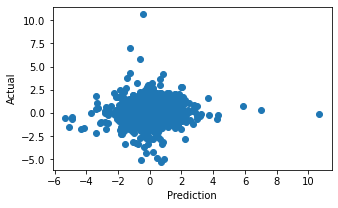

In [19]:
plt.figure(figsize=(5, 3))
plt.scatter(crude_mom_prediction, y_actual*maximum)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

### 4) Output

##### Requested Output:

1. PnL plot (using $10,000 investment on day 1 compounded throughout the 4626 days of the returns series))
2. Monthly return matrix (this is just monthly PnL(columns) by year (rows))
3. Daily return
4. Annualised Sharpe
5. Max drawdown
6. Performance vs. a buy – and – hold strategy

My outputs assume that trading or investment begins on the 3001st day of available data.

In [20]:
output_DF = raw_DF[3000:]

In [21]:
output_DF["Date"] = output_DF["Date"].apply(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y'))

c:\users\wwevans\desktop\github\apple\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
buyandhold_daily, buyandhold_total = compound_actual_returns()

In [23]:
output_DF.loc[:, "BnH Daily"] = buyandhold_daily
output_DF.loc[:, "BnH Total"] = buyandhold_total

c:\users\wwevans\desktop\github\apple\venv\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\wwevans\desktop\github\apple\venv\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
trading_daily_lstm, trading_total_lstm = compound_returns(all_predictions[0]*maximum)
#output_DF["Trading 1 Pred."] = scaler.inverse_transform(all_predictions[0].reshape(-1, 1))
output_DF.loc[:, "Trading LSTM Pred."] = all_predictions[0]*maximum
output_DF.loc[:, "Trading LSTM Daily"] = trading_daily_lstm
output_DF.loc[:, "Trading LSTM Total"] = trading_total_lstm

In [25]:
trading_daily_mom, trading_total_mom = compound_returns(crude_mom_prediction)
output_DF.loc[:, "Trading Mom. Pred."] = crude_mom_prediction
output_DF.loc[:, "Trading Mom. Daily"] = trading_daily_mom
output_DF.loc[:, "Trading Mom. Total"] = trading_total_mom

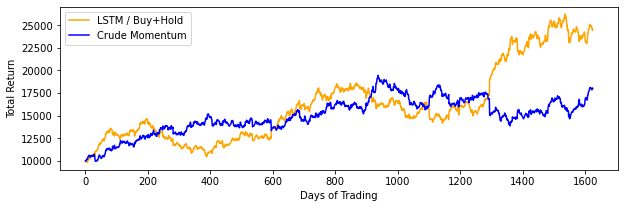

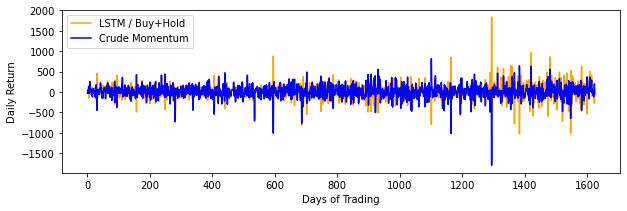

In [26]:
plt.figure(figsize=(10, 3))
plt.plot(output_DF["BnH Total"].values, color='orange', label='LSTM / Buy+Hold')
plt.plot(output_DF["Trading Mom. Total"].values, color='blue', label='Crude Momentum')
plt.xlabel('Days of Trading')
plt.ylabel('Total Return')
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(output_DF["BnH Daily"].values, color='orange', label='LSTM / Buy+Hold')
plt.plot(output_DF["Trading Mom. Daily"].values, color='blue', label='Crude Momentum')
plt.xlabel('Days of Trading')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [27]:
max_drawdown_BnH = max_drawdown(output_DF["BnH Total"], 252)
max_drawdown_mom = max_drawdown(output_DF["Trading Mom. Total"], 252)

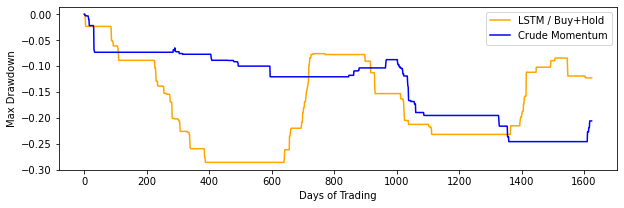

In [28]:
plt.figure(figsize=(10, 3))
plt.plot(max_drawdown_BnH.values, color='orange', label='LSTM / Buy+Hold')
plt.plot(max_drawdown_mom.values, color='blue', label='Crude Momentum')
plt.xlabel('Days of Trading')
plt.ylabel('Max Drawdown')
plt.legend()
plt.show()

In [29]:
def generate_matrix_output(daily_returns_name, total_returns_name, output_DF):
    monthly_PnL = output_DF.groupby([output_DF.Date.dt.year, output_DF.Date.dt.month])[daily_returns_name].sum()
    monthly_opening_balance = output_DF.groupby([output_DF.Date.dt.year, output_DF.Date.dt.month])[total_returns_name].last()
    PnL_matrix_df = create_matrix()
    populate_matrix(PnL_matrix_df, monthly_PnL)
    month_opens_matrix_df = create_matrix()
    populate_matrix(month_opens_matrix_df, monthly_opening_balance)
    annualized_sharpe_matrix_df = create_matrix()
    populate_sharpe_matrix(annualized_sharpe_matrix_df, PnL_matrix_df, month_opens_matrix_df)
    
    return PnL_matrix_df, annualized_sharpe_matrix_df

In [30]:
aapl_PnL_matrix, aapl_sharpe_matrix = generate_matrix_output("BnH Daily", "BnH Total", output_DF)

In [31]:
aapl_PnL_matrix

,January,February,March,April,May,June,July,August,September,October,November,Decemeber
Year,,,,,,,,,,,,
2011,0,0,0,0,0,0,0,0,0,0,0,270.909
2012,878.384,1244.95,758.24,-175.267,-68.3333,105.853,207.217,932.442,-56.6728,-784.543,-96.6357,-576.315
2013,-841.063,-189.955,-26.301,-135.349,97.007,-1042.48,894.535,485.486,-183.687,655.077,650.314,88.5406
2014,-864.901,324.57,222.716,831.731,901.24,374.862,417.306,1202.53,-552.531,634.483,1441.1,-1026.16
2015,362.756,796.181,-416.266,118.101,494.232,-673.13,-569.282,-847.954,-279.656,790.872,-181.451,-1106.53
2016,-633.772,27.7206,1282.98,-1587.8,594.556,-660.448,1006.88,-0.412114,463.371,-52.0823,-563.053,582.605
2017,1277.7,2986.93,1457.6,-41.4788,1469.76,-1206.8,596.717,1792.48,-1353.32,1978.76,112.119,-317.96
2018,-266.66,55.2109,-988.406,-282.046,1427.9,-164.661,0,0,0,0,0,0


In [32]:
aapl_sharpe_matrix

,January,February,March,April,May,June,July,August,September,October,November,Decemeber
Year,,,,,,,,,,,,
2011,0,0,0,0,0,0,0,0,0,0,0,0
2012,0,19.8145,12.4586,3.77386,2.83841,2.59381,2.59381,2.59381,2.59381,2.59381,2.59381,2.59381
2013,1.16378,0.929047,0.845785,0.703182,0.714909,0.0490496,0.0490496,0.0490496,0.0490496,0.0490496,0.0490496,0.0490496
2014,-0.290556,-0.173035,-0.10133,0.139934,0.355367,0.428719,0.428719,0.428719,0.428719,0.428719,0.428719,0.428719
2015,0.483784,0.608768,0.504666,0.508383,0.574297,0.430551,0.430551,0.430551,0.430551,0.430551,0.430551,0.430551
2016,0.28415,0.278427,0.466698,0.153472,0.23539,0.12187,0.12187,0.12187,0.12187,0.12187,0.12187,0.12187
2017,0.270132,0.514383,0.618701,0.602188,0.694812,0.574417,0.574417,0.574417,0.574417,0.574417,0.574417,0.574417
2018,0.544024,0.537265,0.453396,0.424537,0.502051,0.482256,0.482256,0.482256,0.482256,0.482256,0.482256,0.482256


In [33]:
mom_PnL_matrix, mom_sharpe_matrix = generate_matrix_output("Trading Mom. Daily", "Trading Mom. Total", output_DF)

In [34]:
mom_PnL_matrix

,January,February,March,April,May,June,July,August,September,October,November,Decemeber
Year,,,,,,,,,,,,
2011,0,0,0,0,0,0,0,0,0,0,0,511.05
2012,-461.622,515.807,827.538,72.619,544.269,-342.173,521.439,501.001,-133.032,449.226,531.912,-131.068
2013,-355.094,-171.3,725.571,701.469,-293.367,609.211,-592.137,-93.638,342.597,-406.507,409.582,84.5614
2014,-548.284,166.831,452.368,-792.91,4.43868,648.081,803.783,300.226,-827.418,222.959,48.3717,700.383
2015,279.621,591.97,-351.63,155.446,-278.536,-470.51,1716.98,1930.45,-231.142,-1036.35,27.7187,-504.121
2016,-993.62,-267.613,37.3946,1083.98,762.631,-653.064,-933.776,-56.572,170.126,170.731,430.386,396.219
2017,-663.629,-1401,-607.029,-385.439,173.038,316.281,25.1991,603.932,-225.147,868.056,548.323,-500.903
2018,-755.496,103.412,557.698,523.198,1027.28,270.03,0,0,0,0,0,0


In [35]:
mom_sharpe_matrix

,January,February,March,April,May,June,July,August,September,October,November,Decemeber
Year,,,,,,,,,,,,
2011,0,0,0,0,0,0,0,0,0,0,0,0
2012,0,-0.0287976,1.27988,1.22832,1.74788,1.05063,1.05063,1.05063,1.05063,1.05063,1.05063,1.05063
2013,0.608051,0.411796,0.820362,1.13581,0.877101,1.10561,1.10561,1.10561,1.10561,1.10561,1.10561,1.10561
2014,0.728995,0.765502,0.90753,0.486959,0.464427,0.647955,0.647955,0.647955,0.647955,0.647955,0.647955,0.647955
2015,0.703858,0.832011,0.695411,0.71215,0.609591,0.456926,0.456926,0.456926,0.456926,0.456926,0.456926,0.456926
2016,0.195207,0.125379,0.124206,0.31317,0.428966,0.293501,0.293501,0.293501,0.293501,0.293501,0.293501,0.293501
2017,0.163045,-0.0944256,-0.199992,-0.26689,-0.238827,-0.188729,-0.188729,-0.188729,-0.188729,-0.188729,-0.188729,-0.188729
2018,-0.300029,-0.28544,-0.206377,-0.138017,-0.0149886,0.0122546,0.0122546,0.0122546,0.0122546,0.0122546,0.0122546,0.0122546


### Summary

My approach was to try to find a signal in the days preceding 'tomorrow'. My intuition was that only a relatively small input window of days (less than 10) should be used, since the goal was to create a daily trading strategy. If large number of days was used as the input window I felt I would be searching for signals that occurred on timescales of 10-20 days, and there would be fewer of these events for the model to learn from. Therefore first I wanted to see if there was a signal occuring on the timescales of 2-5 days. However if I was to extend the model to include date data this opinion would change, a much large window of about 30-60 days would be my starting point. I would be very interested to go after subjective trading effects, for example Monday opening or Friday close effects.

I applied a neural net model even though 3000 days of data is not really enough data for that type of machine learning. This was mainly for selfish reasons - I wanted to try do some timeseries forecasting with LSTMs.

Although not documented, I explored using different numbers of LSTM layers, different activations and different scalings but all configurations gave a similar result. The LSTM model predicted a small positive increase with a much lower variance than that of AAPL, which was useless since this is the same as a buy and hold strategy. 

I would like to explore splitting the training data into 4 categories: (large increase, small increase, small decrease, large decrease) and using an LSTM and random forest (two separate approaches) to predict between 2 possible outputs: (increase, decrease). I think this strategy would work better since I feel using continuous numbers gives the model too many degrees of freedom to choose from. I can also see from the loss decrease, as the LSTM model is training, that each iteration there is not a lot of optimization happening, which means neural net isn't appropriate, unfortunately I ran out of time to explore further becuase I also wanted to code up the performance metrics.